### Importing Relevant Packages

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

### Loading and Transforming the Data

In [27]:
url = './ignore/S3/L11/Index2018.csv'
raw_csv_data = pd.read_csv(url) 
df=raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst = True)
df.set_index("date", inplace=True)
df=df.asfreq('b')
df=df.fillna(method='ffill')



### Removing Surplus Data

In [28]:
df['market_value']=df.spx

In [29]:
del df['spx']
del df['dax']
del df['ftse']
del df['nikkei']
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [30]:
df_train.tail()

,market_value
date,
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978
2013-04-04,1559.979316
2013-04-05,1553.278930


In [31]:
df_test.head()

,market_value
date,
2013-04-08,1563.071269
2013-04-09,1568.607909
2013-04-10,1587.731827
2013-04-11,1593.369863
2013-04-12,1588.854623


### White Noise

    - to consider a series as white noise, there must be constant mean, constant variance, and no autocorrelation
    - autocorrelation measures the extent of correlation a value is with regards to its past value(s)
    - white noise is a sequence of random data where every value has a time-period associated with it
    

In [35]:
wn = np.random.normal(loc=df_train['market_value'].mean(), scale=df_train['market_value'].std(), size=len(df_train))

In [36]:
df_train['wn'] = wn.copy()

/var/folders/2h/c7dkm6rj2w318lkvfrnrk2c00000gn/T/ipykernel_13917/1929963099.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['wn'] = wn.copy()


In [38]:
df_train.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1091.551227
std,292.559287,293.599116
min,438.920000,78.777810
25%,914.620000,895.415060
50%,1144.650000,1084.080424
75%,1316.280729,1295.072438
max,1570.252238,2050.888558


Text(0.5, 1.0, 'White Noise Time Series')

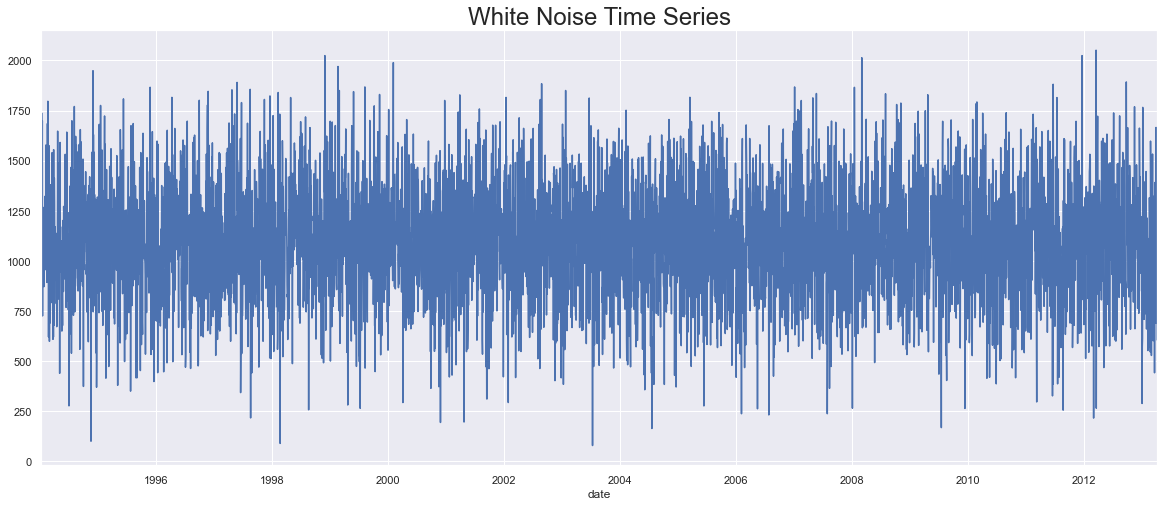

In [43]:
plt.figure(figsize=(20,8))
df_train['wn'].plot()
plt.title("White Noise Time Series", size=24)


Text(0.5, 1.0, 'SPX Time Series')

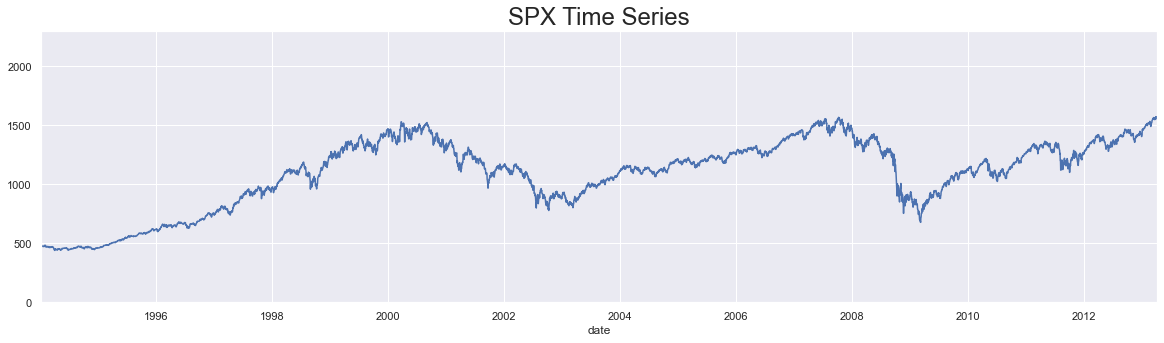

In [46]:
plt.figure(figsize=(20,5))
df_train['market_value'].plot()
plt.ylim(0, 2300)
plt.title("SPX Time Series", size=24)


### Random Walk

    a special type of time series, where values tend to persist over time and the differences between period are smply white noise

In [50]:
url = "./ignore/S5/L22/RandWalk.csv"
rw_raw = pd.read_csv(url)
rw_raw['date'] = pd.to_datetime(rw_raw['date'], dayfirst=True)
rw_raw.set_index('date', inplace=True)
rw_raw.asfreq('b')
rw = rw_raw.copy()

In [51]:
rw.describe()

,price
count,7029.000000
mean,1269.648367
std,443.999180
min,574.382397
25%,931.488599
50%,1155.773451
75%,1488.957260
max,2715.508720


In [57]:
df_train['rw'] = rw

/var/folders/2h/c7dkm6rj2w318lkvfrnrk2c00000gn/T/ipykernel_13917/2070775293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['rw'] = rw


In [59]:
df_train.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1016.899080,1122.139662
1994-01-10,475.27,1264.181075,1080.347860
1994-01-11,474.13,1737.550836,1082.095245
1994-01-12,474.17,1458.308428,1083.639265
1994-01-13,472.47,1280.838803,1067.146255


Text(0.5, 1.0, 'Random Walk')

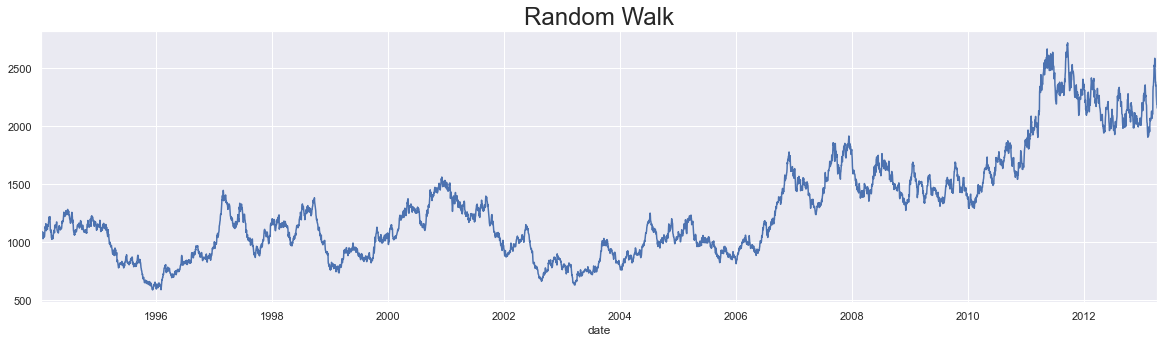

In [63]:
df_train['rw'].plot(figsize=(20, 5))
plt.title('Random Walk', size=24)

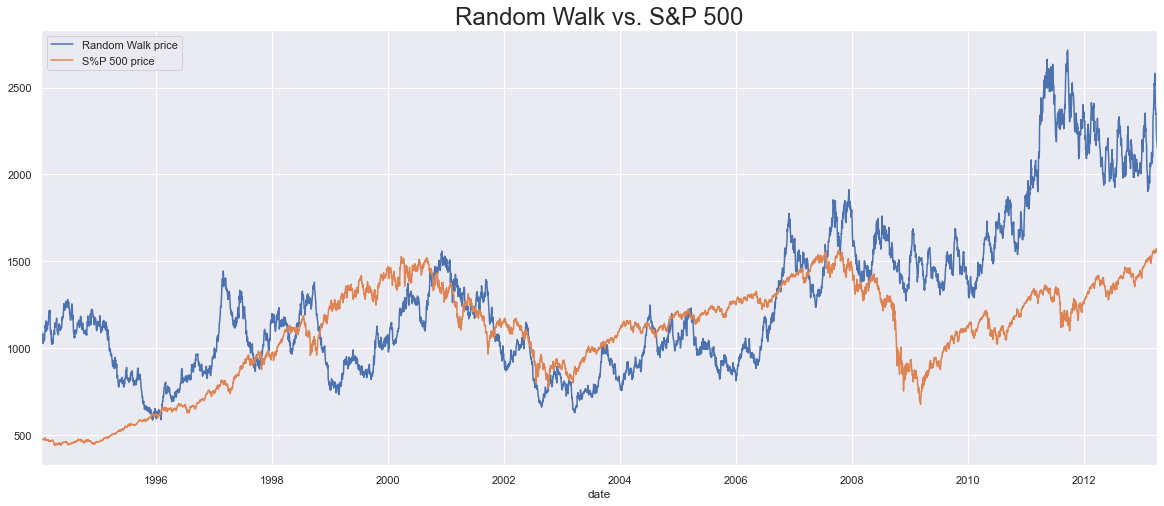

In [69]:
plt.figure(figsize=(20, 8))
df_train['rw'].plot(label = 'Random Walk price')
df_train['market_value'].plot(label = 'S%P 500 price')
plt.title('Random Walk vs. S&P 500', size=24)
plt.legend()

<b>Market Efficiency</b>

    Measures the level of difficulty in forecasting correct future values
    If the time series resembles a random walk, it cannot be predicted with great accuracy. Conversely, if prices can be predicted with great accuracy, there are arbitrage opportunities

<b>Arbitrage</b>

    Buying and selling commodities and make a safe profit, while prices adjust

### Stationarity

    If you take consecutive samples of the same size, both samples should have identical covariances regardless of the starting point. This is also known as 'weak-form' or 'covariance' stationarity

    Assumptions of covariance stationarity:
    (i)   constant mean
    (ii)  constant variance
    (iii) cov(x1, x3) = cov(x4, x6) (i.e. covariance between different starting point and the same number of data points are equal)

    Strict Stationarity
    (i) identical mean and variance

    first criteria is to check for stationarity - DF test + augmented DF test

    DF Test:
    H0: The time series is non-stationary
    H1: The time series is stationary
    test statistic < critical value => stationarity

In [71]:
sts.adfuller(df_train['market_value'])

(-1.7369847452352416,
 0.41216456967706316,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

    no significance evidence of stationarity

In [72]:
sts.adfuller(df_train['wn'])

(-69.77948866718967,
 0.0,
 0,
 5020,
 {'1%': -3.431653316130827,
  '5%': -2.8621159253018247,
  '10%': -2.5670765656497516},
 70845.12573680657)

    significant evidence of stationarity

In [73]:
sts.adfuller(df_train['rw'])

(-1.328607392768973,
 0.6159849181617378,
 24,
 4996,
 {'1%': -3.4316595802782865,
  '5%': -2.8621186927706463,
  '10%': -2.567078038881065},
 46299.333497595144)

no significant evidence of stationarity

### Seasonality

    suggests that trends will appear in cyclical basis
    decompose into 3 effects
    - trend: pattern in the data
    - seasonal: cyclical effects
    - residual: error of prediction (you should see white noise here)

    "naive" decomposition
    additive:       observed = trend + seasonal + residual
    mulitplicative: observed = trend * seasonal * residual

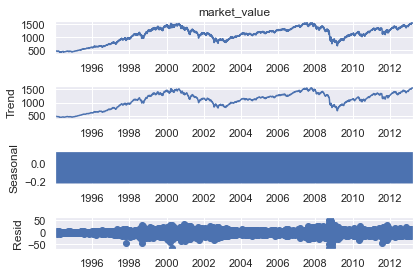

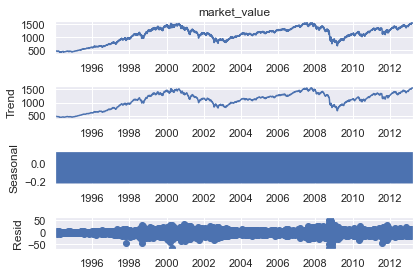

In [81]:
season_decompose_add = seasonal_decompose(df_train['market_value'], model='additive')
season_decompose_add.plot()

    residual represents the difference between true values and predictions for any period. The increased in residual volatility corresponds to the dot com and housing prices bubbles in 2000 and 2008 respectively


    this plot suggests to seasonality in the time series dataset

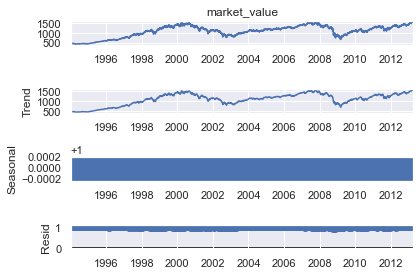

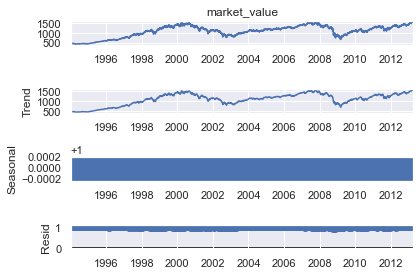

In [82]:
season_decompose_add = seasonal_decompose(df_train['market_value'], model='mutiplicative')
season_decompose_add.plot()

### ACF

    Correlation: correlation measures the similarity in the change of values of two series
    Auto-Correlation (Function)(ACF): the correlation between a sequence and itself

In [ ]:
# import statsmodels.graphics.tsaplots as sgt

Text(0, 0.5, 'Auto-correlation coefficient')

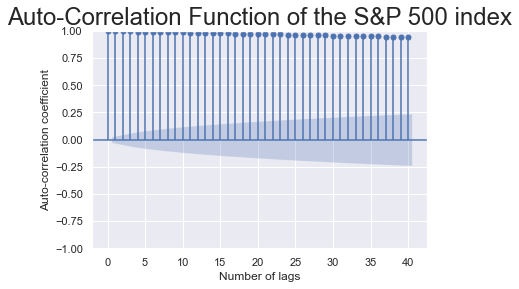

In [85]:
sgt.plot_acf(df_train['market_value'], lags=40, zero = True)
plt.title("Auto-Correlation Function of the S&P 500 index", size=24)
plt.xlabel("Number of lags")
plt.ylabel("Auto-correlation coefficient")

    High autocorrelation

Text(0, 0.5, 'Auto-correlation coefficient')

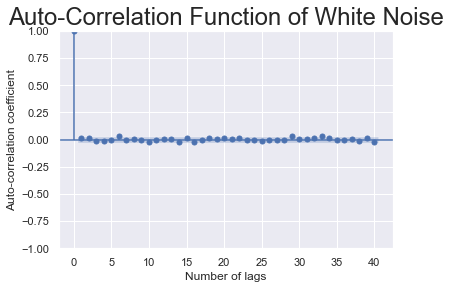

In [88]:
sgt.plot_acf(df_train['wn'], lags=40, zero = True)
plt.title("Auto-Correlation Function of White Noise", size=24)
plt.xlabel("Number of lags")
plt.ylabel("Auto-correlation coefficient")

    No autocorrelation in white noise

Text(0, 0.5, 'Auto-correlation coefficient')

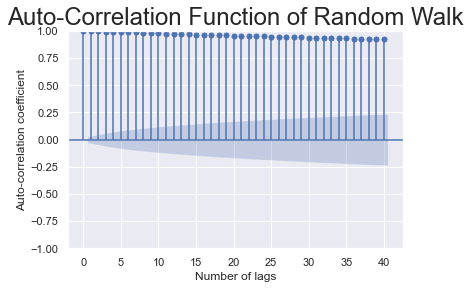

In [89]:
sgt.plot_acf(df_train['rw'], lags=40, zero = True)
plt.title("Auto-Correlation Function of Random Walk", size=24)
plt.xlabel("Number of lags")
plt.ylabel("Auto-correlation coefficient")

    High autocorrelation

### PACF

    Autocorrelation measures the similarity between the current value and a lagged version of itself. However, this also captures second-hand effects (indirect effects), such as the relation between the similarity between the second and third, which is propogated into the calculation of autocorrelation.
    To determine only the direct relationship between the time series and its lagged version, we need partial auto-correlation (PACF) 

(-0.1, 1.0)

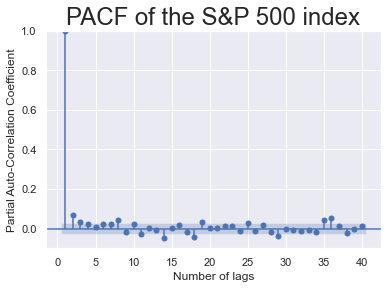

In [94]:
sgt.plot_pacf(df_train['market_value'], lags=40, zero = False, method=('ols'))
plt.title("PACF of the S&P 500 index", size=24)
plt.xlabel("Number of lags")
plt.ylabel("Partial Auto-Correlation Coefficient")
plt.ylim(-0.1, 1)

    ACF and PACF values for the first lag should be identical because there are no other channels in which past values can affect present values
    No PACT effects

(-0.2, 0.2)

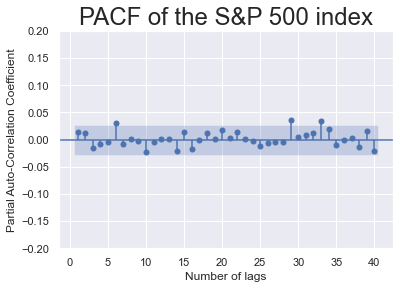

In [96]:
sgt.plot_pacf(df_train['wn'], lags=40, zero = False, method=('ols'))
plt.title("PACF of the S&P 500 index", size=24)
plt.xlabel("Number of lags")
plt.ylabel("Partial Auto-Correlation Coefficient")
plt.ylim(-0.2, 0.2)

(-0.1, 1.1)

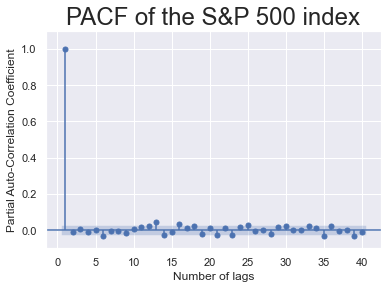

In [100]:
sgt.plot_pacf(df_train['rw'], lags=40, zero = False, method=('ols'))
plt.title("PACF of the S&P 500 index", size=24)
plt.xlabel("Number of lags")
plt.ylabel("Partial Auto-Correlation Coefficient")
plt.ylim(-0.1, 1.1)

### Section 6 - Picking the correct model

    1. Significant Coefficients
    2. Parsimonious (as simple as possible) 
        - generally, simpler model is better than a complex model, unless the complex model provide significantly better predctions
        - Use LLR test (information criteria, AIC/BIC)
    3. Residual should be white noise

    If we are comparing 2 models we want higher log-likelihood and lower information critera